### В данном ноутбуке попробуем построить модель для классификации изображений с сайта https://quickdraw.withgoogle.com/. Данные взяты с формате .npy и представляют из себя 784 пикселя(Ниже примеры). Для моделирования будем использовать библиотеку tensorflow и keras, catboost, 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from os import walk
import re
from tqdm import tqdm
import uuid

df = pd.read_csv('F:\\doodles\\bucket_31.csv')
df = df.append(pd.read_csv('F:\\doodles\\bucket_32.csv'))
df = df.append(pd.read_csv('F:\\doodles\\bucket_33.csv'))
df.drop(columns=['Unnamed: 0'], inplace= True)


In [3]:
df.groupby('category').count()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
category,,,,,,,,,,,,,,,,,,,,,
airplane,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821,...,1821,1821,1821,1821,1821,1821,1821,1821,1821,1821
ambulance,1776,1776,1776,1776,1776,1776,1776,1776,1776,1776,...,1776,1776,1776,1776,1776,1776,1776,1776,1776,1776
angel,1797,1797,1797,1797,1797,1797,1797,1797,1797,1797,...,1797,1797,1797,1797,1797,1797,1797,1797,1797,1797
ant,1497,1497,1497,1497,1497,1497,1497,1497,1497,1497,...,1497,1497,1497,1497,1497,1497,1497,1497,1497,1497
anvil,1515,1515,1515,1515,1515,1515,1515,1515,1515,1515,...,1515,1515,1515,1515,1515,1515,1515,1515,1515,1515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
windmill,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,...,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449
wristwatch,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
yoga,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366,...,3366,3366,3366,3366,3366,3366,3366,3366,3366,3366


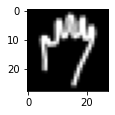

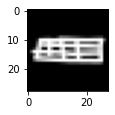

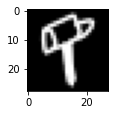

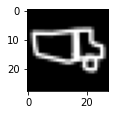

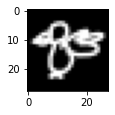

In [4]:
categories = []
for i in range(5):
    sample = df.sample(1)
    pixels = sample.drop(columns=['category']).values.reshape((28, 28))
    categories.append(sample['category'].values[0])
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [5]:
categories

['hand', 'spreadsheet', 'mailbox', 'truck', 'parrot']

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit_transform(df['category'])
df["category_enc"] = le.transform(df['category'])
y = df['category_enc']
to_drop = ['category', 'category_enc']
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=to_drop), y, test_size=0.3,random_state=42)

In [ ]:
from catboost import CatBoostClassifier

clf_cat = CatBoostClassifier(task_type='GPU', max_depth=5)
clf_cat.fit(X_train, y_train)

Learning rate set to 0.216164
0:	learn: 5.3450042	total: 2.5s	remaining: 41m 32s
1:	learn: 5.1265753	total: 5.05s	remaining: 42m 1s
2:	learn: 4.9418775	total: 7.51s	remaining: 41m 34s
3:	learn: 4.8004240	total: 10.1s	remaining: 42m 4s
4:	learn: 4.6884164	total: 12.7s	remaining: 42m 2s
5:	learn: 4.5980428	total: 14.9s	remaining: 41m 13s
6:	learn: 4.4999708	total: 17.5s	remaining: 41m 24s
7:	learn: 4.4248363	total: 19.9s	remaining: 41m 7s
8:	learn: 4.3535911	total: 22.4s	remaining: 41m 4s
9:	learn: 4.2906769	total: 24.6s	remaining: 40m 39s
10:	learn: 4.2282100	total: 27.1s	remaining: 40m 40s
11:	learn: 4.1724970	total: 29.6s	remaining: 40m 35s
12:	learn: 4.1109044	total: 32s	remaining: 40m 32s
13:	learn: 4.0682544	total: 34.3s	remaining: 40m 18s
14:	learn: 4.0158360	total: 36.9s	remaining: 40m 26s
15:	learn: 3.9688694	total: 39.6s	remaining: 40m 33s
16:	learn: 3.9325557	total: 41.8s	remaining: 40m 17s
17:	learn: 3.8894705	total: 44.4s	remaining: 40m 19s
18:	learn: 3.8500454	total: 46.7s	

153:	learn: 2.4468290	total: 5m 46s	remaining: 31m 40s
154:	learn: 2.4434368	total: 5m 48s	remaining: 31m 37s
155:	learn: 2.4402391	total: 5m 50s	remaining: 31m 34s
156:	learn: 2.4367021	total: 5m 52s	remaining: 31m 31s
157:	learn: 2.4336849	total: 5m 54s	remaining: 31m 28s
158:	learn: 2.4294583	total: 5m 56s	remaining: 31m 25s
159:	learn: 2.4276020	total: 5m 58s	remaining: 31m 21s
160:	learn: 2.4258545	total: 6m	remaining: 31m 18s
161:	learn: 2.4254221	total: 6m 2s	remaining: 31m 14s
162:	learn: 2.4215245	total: 6m 4s	remaining: 31m 11s
163:	learn: 2.4197795	total: 6m 6s	remaining: 31m 7s
164:	learn: 2.4180425	total: 6m 8s	remaining: 31m 4s
165:	learn: 2.4171356	total: 6m 10s	remaining: 31m
166:	learn: 2.4131759	total: 6m 12s	remaining: 30m 58s
167:	learn: 2.4096908	total: 6m 14s	remaining: 30m 55s
168:	learn: 2.4068832	total: 6m 16s	remaining: 30m 52s
169:	learn: 2.4050663	total: 6m 18s	remaining: 30m 48s
170:	learn: 2.3991130	total: 6m 20s	remaining: 30m 46s
171:	learn: 2.3958288	to

303:	learn: 2.1723547	total: 10m 44s	remaining: 24m 36s
304:	learn: 2.1717255	total: 10m 46s	remaining: 24m 33s
305:	learn: 2.1702777	total: 10m 48s	remaining: 24m 31s
306:	learn: 2.1681402	total: 10m 50s	remaining: 24m 28s
307:	learn: 2.1669767	total: 10m 52s	remaining: 24m 26s
308:	learn: 2.1620582	total: 10m 55s	remaining: 24m 24s
309:	learn: 2.1606441	total: 10m 57s	remaining: 24m 22s
310:	learn: 2.1602353	total: 10m 58s	remaining: 24m 19s
311:	learn: 2.1600749	total: 11m	remaining: 24m 17s
312:	learn: 2.1594541	total: 11m 2s	remaining: 24m 14s
313:	learn: 2.1580661	total: 11m 4s	remaining: 24m 12s
314:	learn: 2.1547440	total: 11m 6s	remaining: 24m 10s
315:	learn: 2.1539761	total: 11m 8s	remaining: 24m 7s
316:	learn: 2.1538076	total: 11m 10s	remaining: 24m 4s
317:	learn: 2.1530077	total: 11m 12s	remaining: 24m 2s
318:	learn: 2.1522574	total: 11m 14s	remaining: 23m 59s
319:	learn: 2.1515665	total: 11m 16s	remaining: 23m 57s
320:	learn: 2.1511199	total: 11m 18s	remaining: 23m 54s
321

451:	learn: 2.0009613	total: 15m 37s	remaining: 18m 56s
452:	learn: 2.0003534	total: 15m 39s	remaining: 18m 54s
453:	learn: 1.9983487	total: 15m 41s	remaining: 18m 51s
454:	learn: 1.9976963	total: 15m 43s	remaining: 18m 49s
455:	learn: 1.9972642	total: 15m 45s	remaining: 18m 47s
456:	learn: 1.9953062	total: 15m 47s	remaining: 18m 45s
457:	learn: 1.9945105	total: 15m 49s	remaining: 18m 43s
458:	learn: 1.9916231	total: 15m 51s	remaining: 18m 41s
459:	learn: 1.9908262	total: 15m 53s	remaining: 18m 38s
460:	learn: 1.9905287	total: 15m 55s	remaining: 18m 36s
461:	learn: 1.9899994	total: 15m 56s	remaining: 18m 34s
462:	learn: 1.9895163	total: 15m 58s	remaining: 18m 32s
463:	learn: 1.9881394	total: 16m	remaining: 18m 29s
464:	learn: 1.9863881	total: 16m 2s	remaining: 18m 27s
465:	learn: 1.9857451	total: 16m 4s	remaining: 18m 25s
466:	learn: 1.9853787	total: 16m 6s	remaining: 18m 23s
467:	learn: 1.9846880	total: 16m 8s	remaining: 18m 20s
468:	learn: 1.9845807	total: 16m 10s	remaining: 18m 18s


599:	learn: 1.8717376	total: 20m 27s	remaining: 13m 38s
600:	learn: 1.8714166	total: 20m 29s	remaining: 13m 36s
601:	learn: 1.8699112	total: 20m 31s	remaining: 13m 34s
602:	learn: 1.8687632	total: 20m 33s	remaining: 13m 32s
603:	learn: 1.8683821	total: 20m 35s	remaining: 13m 30s
604:	learn: 1.8676146	total: 20m 37s	remaining: 13m 27s
605:	learn: 1.8658244	total: 20m 39s	remaining: 13m 25s
606:	learn: 1.8651183	total: 20m 41s	remaining: 13m 23s
607:	learn: 1.8643963	total: 20m 43s	remaining: 13m 21s
608:	learn: 1.8637571	total: 20m 45s	remaining: 13m 19s
609:	learn: 1.8632223	total: 20m 47s	remaining: 13m 17s
610:	learn: 1.8623456	total: 20m 49s	remaining: 13m 15s
611:	learn: 1.8617018	total: 20m 51s	remaining: 13m 13s
612:	learn: 1.8610752	total: 20m 53s	remaining: 13m 11s
613:	learn: 1.8601319	total: 20m 55s	remaining: 13m 9s
614:	learn: 1.8585987	total: 20m 57s	remaining: 13m 7s
615:	learn: 1.8576171	total: 20m 59s	remaining: 13m 4s
616:	learn: 1.8572582	total: 21m 1s	remaining: 13m 

748:	learn: 1.7563494	total: 25m 21s	remaining: 8m 29s
749:	learn: 1.7559027	total: 25m 23s	remaining: 8m 27s
750:	learn: 1.7550139	total: 25m 25s	remaining: 8m 25s
751:	learn: 1.7544031	total: 25m 27s	remaining: 8m 23s
752:	learn: 1.7542030	total: 25m 29s	remaining: 8m 21s
753:	learn: 1.7534962	total: 25m 31s	remaining: 8m 19s
754:	learn: 1.7531447	total: 25m 32s	remaining: 8m 17s
755:	learn: 1.7525711	total: 25m 34s	remaining: 8m 15s
756:	learn: 1.7524156	total: 25m 36s	remaining: 8m 13s
757:	learn: 1.7518842	total: 25m 38s	remaining: 8m 11s
758:	learn: 1.7510562	total: 25m 40s	remaining: 8m 9s
759:	learn: 1.7507379	total: 25m 42s	remaining: 8m 7s
760:	learn: 1.7500342	total: 25m 44s	remaining: 8m 5s
761:	learn: 1.7493583	total: 25m 46s	remaining: 8m 3s
762:	learn: 1.7476956	total: 25m 48s	remaining: 8m 1s
763:	learn: 1.7474931	total: 25m 50s	remaining: 7m 58s
764:	learn: 1.7470839	total: 25m 52s	remaining: 7m 56s
765:	learn: 1.7467348	total: 25m 54s	remaining: 7m 54s
766:	learn: 1.7

899:	learn: 1.6484370	total: 30m 21s	remaining: 3m 22s
900:	learn: 1.6471497	total: 30m 23s	remaining: 3m 20s
901:	learn: 1.6463173	total: 30m 25s	remaining: 3m 18s
902:	learn: 1.6455194	total: 30m 27s	remaining: 3m 16s
903:	learn: 1.6446856	total: 30m 30s	remaining: 3m 14s
904:	learn: 1.6445340	total: 30m 31s	remaining: 3m 12s
905:	learn: 1.6443238	total: 30m 33s	remaining: 3m 10s
906:	learn: 1.6438688	total: 30m 35s	remaining: 3m 8s
907:	learn: 1.6427778	total: 30m 37s	remaining: 3m 6s
908:	learn: 1.6421335	total: 30m 39s	remaining: 3m 4s
909:	learn: 1.6413655	total: 30m 41s	remaining: 3m 2s
910:	learn: 1.6411063	total: 30m 43s	remaining: 3m
911:	learn: 1.6402958	total: 30m 45s	remaining: 2m 58s
912:	learn: 1.6401113	total: 30m 47s	remaining: 2m 56s
913:	learn: 1.6390584	total: 30m 49s	remaining: 2m 54s
914:	learn: 1.6385249	total: 30m 51s	remaining: 2m 52s
915:	learn: 1.6382416	total: 30m 53s	remaining: 2m 49s


In [ ]:
from sklearn.metrics import classification_report

y_pred = [*map(lambda x: np.argmax(x), pred)]
report = pd.DataFrame.from_dict(classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)).T
report

In [7]:
import tensorflow as tf
from tensorflow import keras

tf.config.experimental.set_memory_growth(tf.config.get_visible_devices('GPU')[0], True)
DROP_OUT = 4
KERNEL_SIZE = 3
CATEGORIES = len(df['category'].unique())
model = keras.Sequential([
    keras.layers.Reshape((-1,28,28,1)),
    keras.layers.experimental.preprocessing.Rescaling(scale=1./255.),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
        
    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Conv2D(56, kernel_size=KERNEL_SIZE, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Flatten(),

    keras.layers.Dense(CATEGORIES * 10, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Dense(CATEGORIES * 30, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),
    
    keras.layers.Dense(CATEGORIES * 30, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1 * DROP_OUT),

    keras.layers.Dense(CATEGORIES, activation='softmax')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
file = 'F:\\doodles\\dump\\dump'
model = keras.models.load_model(file)

In [9]:
from sklearn.metrics import classification_report
import gc

def free(to_erase):
    for obj in to_erase:
        del(obj)
    gc.collect()
    
def load_val_data(encoder):
    df = pd.read_csv('F:\\doodles\\bucket_249.csv')
    df.drop(columns=['Unnamed: 0'], inplace=True)
    df["category_enc"] = encoder.transform(df['category'])
    y = df['category_enc']
    to_drop = ['category', 'category_enc']
    return (df.drop(columns=to_drop), y)
    
def load_data(i, encoder, pattern ='F:\\doodles\\bucket_{}.csv', test_size = 0.2):
    df = pd.read_csv(pattern.format(str(i)))
    df.drop(columns=['Unnamed: 0'], inplace= True)
    df["category_enc"] = encoder.transform(df['category'])
    y = df['category_enc']
    to_drop = ['category', 'category_enc']
    return train_test_split(df.drop(columns=to_drop), y, test_size=test_size)

def get_report(model, encoder):
    X_test, y_test = load_val_data(le)
    pred = model.predict(X_test)
    y_pred = [*map(lambda x: np.argmax(x), pred)]
    return pd.DataFrame.from_dict(classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)).T

def get_weight(value, mean, max_weight):
    value = mean / value
    return 1 if value <=1 else max_weight if value >= max_weight else value

def get_weights(model, encoder, max_weight=2, metric='f1-score', report = None):
    if report is None:
        report = get_report(model, encoder)
    mean = report[metric].mean()
    return dict((class_, get_weight(report.loc[[class_]][metric][0], mean, max_weight)) for class_ in encoder.classes_)

In [22]:
file = 'F:\\doodles\\dump'
class_weights = None
reports = []
hists = []
for i in tqdm(range(50, 250)):
    try:
        X_train, X_test, y_train, y_test = load_data(i, le)
        hist = model.fit(X_train, y_train,
                         epochs=7,
                         batch_size=250,
                         validation_data=(X_test, y_test),
                         class_weight=class_weights)
        
        hists.append(hist)
        
        if i % 10 == 0:
            model.save(file)  
            
        free([X_train, X_test, y_train, y_test])
        
        report = get_report(model, le)  
        reports.append(report)
    except KeyboardInterrupt:
        print("Stopped. Current bucket is {}".format(str(i)))
        break

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/7
555/555 [==============================] - 47s 84ms/step - loss: 1.2468 - accuracy: 0.6893 - val_loss: 1.0395 - val_accuracy: 0.7398
Epoch 2/7
555/555 [==============================] - 48s 86ms/step - loss: 1.1818 - accuracy: 0.7024 - val_loss: 1.0736 - val_accuracy: 0.7314
Epoch 3/7
555/555 [==============================] - 47s 85ms/step - loss: 1.1247 - accuracy: 0.7114 - val_loss: 1.1044 - val_accuracy: 0.7366
Epoch 4/7
555/555 [==============================] - 47s 85ms/step - loss: 1.0714 - accuracy: 0.7209 - val_loss: 1.0990 - val_accuracy: 0.7277
Epoch 5/7
555/555 [==============================] - 47s 85ms/step - loss: 1.0246 - accuracy: 0.7312 - val_loss: 1.1011 - val_accuracy: 0.7292
Epoch 6/7
555/555 [==============================] - 47s 85ms/step - loss: 0.9714 - accuracy: 0.7410 - val_loss: 1.1407 - val_accuracy: 0.7250
Epoch 7/7
555/555 [==============================] - 47s 85ms/step - loss: 0.9307 - accuracy: 0.7493 - val_loss: 1.1419 - val_accuracy: 0.7258

  0%|          | 1/200 [06:29<21:33:21, 389.96s/it]


MemoryError: Unable to allocate 1.01 GiB for an array with shape (785, 173377) and data type int64

In [10]:
report = get_report(model, le)
report

,precision,recall,f1-score,support
airplane,0.773994,0.825083,0.798722,606.000000
ambulance,0.779956,0.604730,0.681256,592.000000
angel,0.870912,0.846154,0.858355,598.000000
ant,0.722222,0.730924,0.726547,498.000000
anvil,0.879650,0.797619,0.836629,504.000000
...,...,...,...,...
zebra,0.673021,0.794118,0.728571,578.000000
zigzag,0.648387,0.837500,0.730909,480.000000
accuracy,0.715104,0.715104,0.715104,0.715104
macro avg,0.721180,0.714607,0.712971,173158.000000


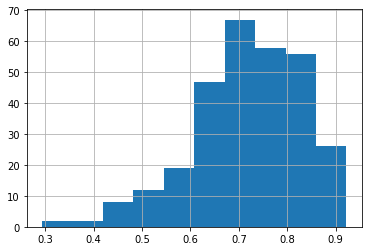

In [23]:
for report in reports:
    report['f1-score'].hist()
    plt.show()

In [24]:
class_weights = get_weights(model, le, report=report)
class_weights

{'airplane': 1,
 'ambulance': 1,
 'angel': 1,
 'ant': 1,
 'anvil': 1,
 'apple': 1,
 'arm': 1.0957077578714876,
 'asparagus': 1.2501919523991316,
 'axe': 1,
 'backpack': 1,
 'banana': 1,
 'bandage': 1,
 'barn': 1.0946439914726842,
 'baseball': 1,
 'basket': 1.0825398594530447,
 'basketball': 1.0286291581606029,
 'bat': 1.0399830099413772,
 'bathtub': 1,
 'beach': 1.1970369764389983,
 'bear': 2,
 'beard': 1.0204125120262169,
 'bed': 1,
 'bee': 1,
 'belt': 1.0423276639525851,
 'bench': 1.263240232184227,
 'bicycle': 1.0180802139320888,
 'binoculars': 1,
 'bird': 1.6475572050687544,
 'blackberry': 1.521648018893522,
 'blueberry': 1.2473214719725818,
 'book': 1,
 'boomerang': 1.0004747719499596,
 'bottlecap': 1.120863227189119,
 'bowtie': 1,
 'bracelet': 1.1321161893117964,
 'brain': 1.1356391247110262,
 'bread': 1.1118145276891167,
 'bridge': 1.0660205823769755,
 'broccoli': 1.0479331906193807,
 'broom': 1.2456476150761149,
 'bucket': 1,
 'bulldozer': 1,
 'bus': 1,
 'bush': 1.4795092027325

In [25]:
[report['f1-score'].mean() for report in reports]

[0.7170069198974711]

In [ ]:
import seaborn as sns

sns.lineplot(y=[report['f1-score'].median() for report in reports], x = range(len(reports)))

<AxesSubplot:>

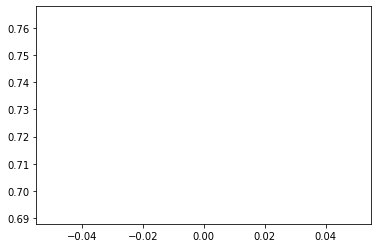

In [26]:
import seaborn as sns

sns.lineplot(y=[report['f1-score'].median() for report in reports], x = range(len(reports)))